In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\| **Autograd** \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Automatic Differentiation with `torch.autograd`
===============================================

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation
engine called `torch.autograd`. It supports automatic computation of
gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`,
parameters `w` and `b`, and some loss function. It can be defined in
PyTorch in the following manner:


In [2]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)#binary_cross_entropy_with_logits？

Tensors, Functions and Computational graph
==========================================

This code defines the following **computational graph**:

![](https://pytorch.org/tutorials/_static/img/basics/comp-graph.png)

In this network, `w` and `b` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the `requires_grad` property of those tensors.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>You can set the value of <code>requires_grad</code> when creating atensor, or later by using <code>x.requires_grad_(True)</code> method.</p>

</div>



A function that we apply to tensors to construct computational graph is
in fact an object of class `Function`.

？ Function

 This object knows how to compute
the function in the *forward* direction, and also how to compute its
derivative 导数 during the *backward propagation* step. A reference to the
backward propagation function is stored in `grad_fn` property of a
tensor. You can find more information of `Function` [in the
documentation](https://pytorch.org/docs/stable/autograd.html#function).


In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7dbc8c61ee90>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7dbc8c61f8e0>


Computing Gradients
===================

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of `x` and
`y`. To compute those derivatives, we call `loss.backward()`, and then
retrieve the values from `w.grad` and `b.grad`:


In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2862, 0.3079, 0.0068],
        [0.2862, 0.3079, 0.0068],
        [0.2862, 0.3079, 0.0068],
        [0.2862, 0.3079, 0.0068],
        [0.2862, 0.3079, 0.0068]])
tensor([0.2862, 0.3079, 0.0068])


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<ul>
<li>We can only obtain the <code>grad</code> properties for the leafnodes of the computational graph, which have <code>requires_grad</code> propertyset to <code>True</code>. For all other nodes in our graph, gradients will not beavailable.- We can only perform gradient calculations using<code>backward</code> once on a given graph, for performance reasons. If we needto do several <code>backward</code> calls on the same graph, we need to pass<code>retain_graph=True</code> to the <code>backward</code> call.</li>
</ul>
```

</div>



Disabling Gradient Tracking
===========================

By default, all tensors with `requires_grad=True` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
`torch.no_grad()` block:


In [5]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method
on the tensor:


In [6]:
z = torch.matmul(x, w)+b
z_det = z.detach()#返回一个与 z 共享数据但从计算图中“切断”的张量视图；之后对 z_det 的操作不会回传到生成 z 的那条图上。
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:

:   -   To mark some parameters in your neural network as **frozen
        parameters**.
    -   To **speed up computations** when you are only doing forward
        pass, because computations on tensors that do not track
        gradients would be more efficient.


More on Computational Graphs
============================

Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

-   run the requested operation to compute a resulting tensor
-   maintain the operation's *gradient function* in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG
root. `autograd` then:

-   computes the gradients from each `.grad_fn`,
-   accumulates them in the respective tensor's `.grad` attribute
-   using the chain rule, propagates all the way to the leaf tensors.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>An important thing to note is that the graph is recreated from scratch; after each<code>.backward()</code> call, autograd starts populating a new graph. This isexactly what allows you to use control flow statements in your model;you can change the shape, size and operations at every iteration ifneeded.</p>

</div>



Optional Reading: Tensor Gradients and Jacobian Products
========================================================

In many cases, we have a scalar loss function, and we need to compute
the gradient with respect to some parameters. However, there are cases
when the output function is an arbitrary tensor. In this case, PyTorch
allows you to compute so-called **Jacobian product**, and not the actual
gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of $\vec{y}$ with
respect to $\vec{x}$ is given by **Jacobian matrix**:

$$\begin{aligned}
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
\end{aligned}$$

Instead of computing the Jacobian matrix itself, PyTorch allows you to
compute **Jacobian Product** $v^T\cdot J$ for a given input vector
$v=(v_1 \dots v_m)$. This is achieved by calling `backward` with $v$ as
an argument. The size of $v$ should be the same as the size of the
original tensor, with respect to which we want to compute the product:


In [7]:
inp = torch.eye(4, 5, requires_grad=True)
#创建4×5 的“单位矩阵形状”张量（主对角线为 1，其余为 0），并开启梯度追踪；inp 是叶子张量，之后 inp.grad 会保存梯度。

out = (inp+1).pow(2).t()
#out = (inp+1).pow(2).t()


out.backward(torch.ones_like(out), retain_graph=True)
#因为 out 不是标量，必须提供“上游梯度”向量 v；这里用全 1 张量，表示计算 out 对 inp 的梯度等价的 VJP
#retain_graph=True：保留计算图，允许后续再次对同一 out 调用 backward

print(f"First call\n{inp.grad}")

out.backward(torch.ones_like(out), retain_graph=True)
#

print(f"\nSecond call\n{inp.grad}")

inp.grad.zero_()#inp.grad.zero_()：把梯度清零（原地置 0）

out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call `backward` for the second time with the same
argument, the value of the gradient is different. This happens because
when doing `backward` propagation, PyTorch **accumulates the
gradients**, i.e. the value of computed gradients is added to the `grad`
property of all leaf nodes of computational graph. If you want to
compute the proper gradients, you need to zero out the `grad` property
before. In real-life training an *optimizer* helps us to do this.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Previously we were calling <code>backward()</code> function withoutparameters. This is essentially equivalent to calling<code>backward(torch.tensor(1.0))</code>, which is a useful way to compute thegradients in case of a scalar-valued function, such as loss duringneural network training.</p>

</div>

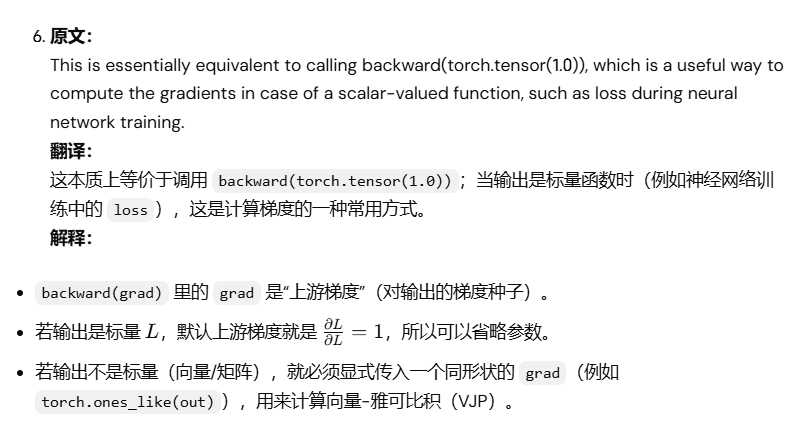



------------------------------------------------------------------------


In [1]:
import torch
x = torch.randn(3, requires_grad=True)
y = (x * 2).sum()

print(y.grad_fn)          # <SumBackward...>
print(y.grad_fn.next_functions)  # 指向上游节点（链式法则要用）

((<MulBackward0 object at 0x79af1d317310>, 0),)


In [2]:
import torch

class MySquare(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * x

    @staticmethod
    def backward(ctx, grad_out):
        (x,) = ctx.saved_tensors
        return grad_out * 2 * x

x = torch.tensor([3.0], requires_grad=True)
y = MySquare.apply(x)
y.backward()
print(x.grad)  # tensor([6.])

tensor([6.])


Further Reading
===============

-   [Autograd
    Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)
